<a href="https://colab.research.google.com/github/kapex13/Docker_compose/blob/main/Transformers_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задание 1

Векторизируй с помощью ruBERT-tiny2 сообщения телеграм каналов.
Используй полученные эмбеддинги в качестве обучающих данных для логистической регрессии и случайного леса и сравни результаты этих моделей:
Построй confusion matrix и выведи f1_macro для двух классификаторов на валидационной части выборки
Выбери несколько сообщений из разных тем, классифицированных неверно, и распечатай их

In [8]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.preprocessing import LabelEncoder


train_df = pd.read_csv("train_channels.csv")
val_df = pd.read_csv("val_channels.csv")

# Извлекаем тексты и метки
X_train_texts = train_df["initial_text"].astype(str).tolist()
y_train = train_df["label"].astype(str)

X_val_texts = val_df["initial_text"].astype(str).tolist()
y_val = val_df["label"].astype(str)



In [9]:
!pip install -q -U sentence-transformers

model = SentenceTransformer('cointegrated/rubert-tiny2')

# Векторизация
X_train = model.encode(X_train_texts, show_progress_bar=True)
X_val = model.encode(X_val_texts, show_progress_bar=True)


Batches:   0%|          | 0/776 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Batches:   0%|          | 0/194 [00:00<?, ?it/s]

In [10]:
# Кодируем категориальные метки в числа
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc = label_encoder.transform(y_val)

# Логистическая регрессия
clf_lr = LogisticRegression(max_iter=1000, random_state=42)
clf_lr.fit(X_train, y_train_enc)

# Случайный лес
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train, y_train_enc)


RandomForestClassifier(random_state=42)

Logistic Regression F1_macro: 0.792
Random Forest       F1_macro: 0.756


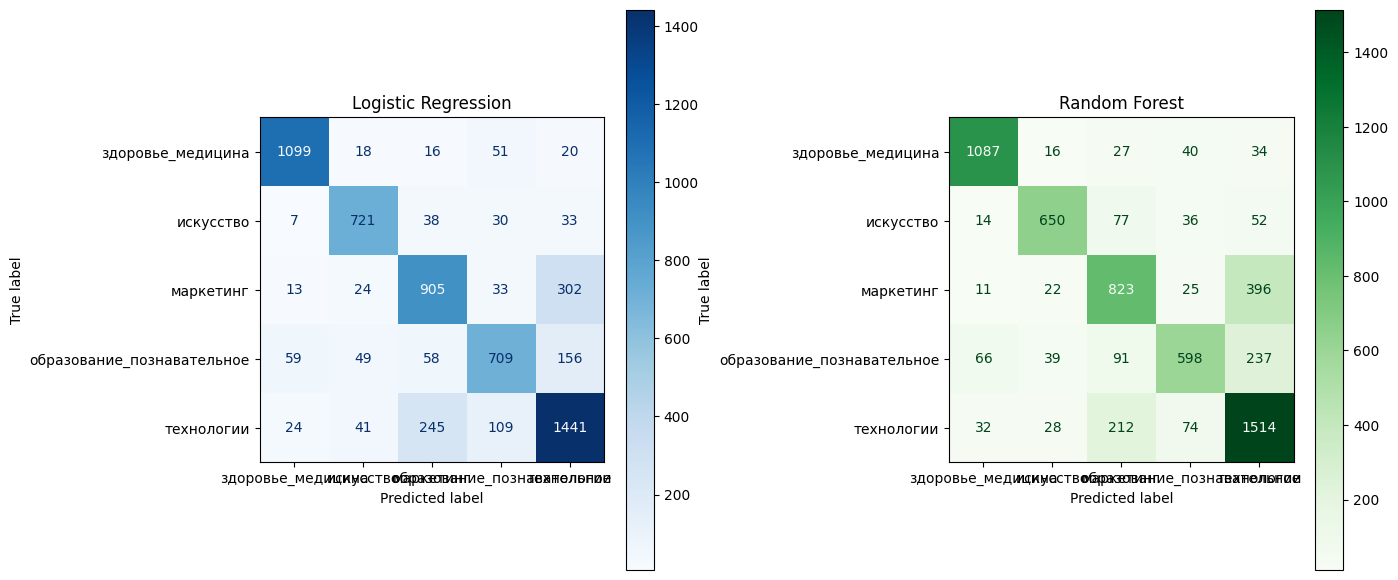

In [11]:
# Предсказания
y_pred_lr = clf_lr.predict(X_val)
y_pred_rf = clf_rf.predict(X_val)

# F1 macro
f1_lr = f1_score(y_val_enc, y_pred_lr, average='macro')
f1_rf = f1_score(y_val_enc, y_pred_rf, average='macro')

print(f"Logistic Regression F1_macro: {f1_lr:.3f}")
print(f"Random Forest       F1_macro: {f1_rf:.3f}")

# Матрицы ошибок
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

ConfusionMatrixDisplay.from_predictions(
    y_val_enc, y_pred_lr,
    display_labels=label_encoder.classes_,
    ax=axs[0], cmap='Blues'
)
axs[0].set_title("Logistic Regression")

ConfusionMatrixDisplay.from_predictions(
    y_val_enc, y_pred_rf,
    display_labels=label_encoder.classes_,
    ax=axs[1], cmap='Greens'
)
axs[1].set_title("Random Forest")

plt.tight_layout()
plt.show()


In [12]:
# Находим ошибочные индексы
misclassified_lr = np.where(y_pred_lr != y_val_enc)[0]
misclassified_rf = np.where(y_pred_rf != y_val_enc)[0]

print("\nПримеры ошибок Логистической регрессии:")
for i in misclassified_lr[:5]:
    true_label = label_encoder.inverse_transform([y_val_enc[i]])[0]
    pred_label = label_encoder.inverse_transform([y_pred_lr[i]])[0]
    print(f"\nТекст: {X_val_texts[i]}")
    print(f"Истинная метка: {true_label}")
    print(f"Предсказано:    {pred_label}")

print("\nПримеры ошибок Случайного леса:")
for i in misclassified_rf[:5]:
    true_label = label_encoder.inverse_transform([y_val_enc[i]])[0]
    pred_label = label_encoder.inverse_transform([y_pred_rf[i]])[0]
    print(f"\nТекст: {X_val_texts[i]}")
    print(f"Истинная метка: {true_label}")
    print(f"Предсказано:    {pred_label}")



Примеры ошибок Логистической регрессии:

Текст: Гид покупателя: разбираемся в тонкостях умных детских часов https://mobile-review.com/all/articles/guide/gid-pokupatelya-razbiraemsya-v-tonkostyah-umnyh-detskih-chasov/Советы тем, кто нацелен на покупку часов для детей: о габаритах, экране, автономности, связи и многом другом…
Истинная метка: технологии
Предсказано:    образование_познавательное

Текст: 🥚 Главное при составлении резюме — составить его вообще. Сегодня разбираемся, как правильно составить резюме, которое понравится отделу кадров, руководителю, да и вам самим. Если вкратце, то: 1️⃣ Будьте лаконичны,2️⃣ Составляйте отдельное резюме для каждой вакансии, на которую откликаетесь,3️⃣ Честно рассказывайте об опыте и навыках,4️⃣ Проверяйте все граматические и пунктуационные, ошибки, опечтки и двойные  пробелы.В этом материале рассказываем об идеальной структуре документа, даём советы по оформлению и сопроводительному письму. Изучайте, а потом ждём ваши резюме по нашим вакансиям
Ис

In [5]:
df_train = pd.read_csv('train_channels.csv')
df_train.head()

,date,content,label,initial_text
0,2023-07-05 15:16:45+00:00,Две ссылкиРас: https://t.me/PlushevChannel/224...,технологии,Две ссылкиРас: https://t.me/PlushevChannel/224...
1,2023-07-11 13:13:02+00:00,"@firstartclub | #обзор«Отец», Константин Аполл...",искусство,"@firstartclub | #обзор«Отец», Константин Аполл..."
2,2022-12-17 07:55:28+00:00,"pov: когда объясняют новую тему урока, а ты ещ...",образование_познавательное,"pov: когда объясняют новую тему урока, а ты ещ..."
3,2023-05-25 10:37:54+00:00,⚡️Грузинская авиакомпания Georgian Airways зап...,маркетинг,⚡️Грузинская авиакомпания Georgian Airways зап...
4,2020-08-03 10:01:15+00:00,"Интересуешься историей и людьми, которые ее со...",образование_познавательное,"Интересуешься историей и людьми, которые ее со..."


In [7]:
df_val = pd.read_csv('test_channels.csv')
df_val.head()

,date,content,label,initial_text
0,2023-05-24 06:42:11+00:00,Мастерство заголовков от РБК Прочитал заголово...,маркетинг,Мастерство заголовков от РБК Прочитал заголово...
1,2023-09-18 12:30:05+00:00,​Революция в оптимизаторах: DeepMind используе...,технологии,​Революция в оптимизаторах: DeepMind используе...
2,2022-10-10 06:25:33+00:00,Телеведущий Эта профессия считается довольно...,образование_познавательное,Телеведущий Эта профессия считается довольно...
3,2021-10-01 10:37:00+00:00,"​Когда-нибудь задумывались, что из-за поврежде...",здоровье_медицина,"​Когда-нибудь задумывались, что из-за поврежде..."
4,2023-02-12 13:04:31+00:00,Эта собака провела в отделении интенсивной тер...,здоровье_медицина,Эта собака провела в отделении интенсивной тер...
